"""
test_make_rc_of_cdcm.py
This python file tests the making of RC system corresponding
to a YABML building.

Author(s):
    Sreehari Manikkan
Date:
    06/29/2022
"""

In [1]:
import h5py
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from cdcm import *
from yabml import *

from rc_system import RCBuildingSystem
from rc_system import make_rc_of_cdcm
from single_zone_deterministic import single_zone_building

In [2]:
# ---------- RC System of a deterministic zone-----------------#

zone = single_zone_building.zones[0]
neighbor = single_zone_building.neighbor[0]

df = pd.read_csv("rc_system_data/weather_data_2017_pandas.csv")

Q_int = Variable(
    name="Q_int",
    units="W",
    value=150,
    description="Sum of internal heat gain"
)

u_t = Variable(
    name="u_t",
    units="W",
    value=0.0,
    description="Input loads"
)

T_cor = Variable(
    name="T_cor",
    units="degC",
    value=23,
    description="Corridor temperature"
)
with System(name="zone_sys_det") as zone_sys_det:
    
    ## clock system
    clock = make_clock(1800)
    
    ## weather system
    weather_sys = make_data_system(
        df[["Tout", "Qsg"]],
        name="weather_system",
        column_units=["degC", "W"],
        column_desciptions=[
            "Outdoor air temperature",
            "Solar irradiance"
        ]
    )
    
    ## rc system
    det_zone_rc_sys = RCBuildingSystem(dt=clock.dt,
                              weather_system=weather_sys,
                              T_cor=T_cor,
                              Q_int=Q_int,
                              u=u_t,
                              name="det_zone_rc_sys")

## fetching information from yabml to cdcm rc system
det_zone_rc_sys = make_rc_of_cdcm(zone, neighbor, det_zone_rc_sys)

In [3]:
print('------ R C values of the current zone -------')
print(f"""
C_room={det_zone_rc_sys.C_room.value},
C_env={zone_sys_det.det_zone_rc_sys.C_env.value},
C_genv={zone_sys_det.det_zone_rc_sys.C_genv.value},
R_rc={zone_sys_det.det_zone_rc_sys.R_rc.value},
R_oe={zone_sys_det.det_zone_rc_sys.R_oe.value},
R_er={zone_sys_det.det_zone_rc_sys.R_er.value},
R_gr={zone_sys_det.det_zone_rc_sys.R_gr.value},
R_ge={zone_sys_det.det_zone_rc_sys.R_ge.value}""")

------ R C values of the current zone -------

C_room=2716200.0,
C_env=365979326.4446341,
C_genv=18416165.01274456,
R_rc=inf,
R_oe=0.0011510797727914478,
R_er=0.15368453333333335,
R_gr=0.021954933333333336,
R_ge=0.010606654259043315


In [4]:
print(zone_sys_det)

zone_sys_det:
  description: ''
  owner: ''
  nodes:
    clock:
      description: A system that counts time.
      owner: zone_sys_det
      nodes:
        dt:
          description: The timestep.
          owner: zone_sys_det/clock
          parents: ()
          children: ('tick', 'zone_sys_det/det_zone_rc_sys/make_matrices', 'zone_sys_det/det_zone_rc_sys/transition_room')
          value: 1800
          units: seconds
          track: true
        t:
          description: The time.
          owner: zone_sys_det/clock
          parents: ('tick',)
          children: ('tick',)
          value: 0.0
          units: seconds
          track: true
        tick:
          description: Moves time forward by `dt`.
          owner: zone_sys_det/clock
          parents: ('t', 'dt')
          children: ('t',)
          func: !!python/name:cdcm.clock.tick ''
    weather_system:
      description: ''
      owner: zone_sys_det
      nodes:
        Tout:
          description: Outdoor air tempera

In [5]:
## ------ Simulating the system -----------##
max_steps = 1000
file_name = "test_make_rc_of_cdcm_det.h5"

if os.path.exists(file_name):
        os.remove(file_name)

for i in range(max_steps):
    zone_sys_det.forward()
    if i == 0:
        test_saver_det = SimulationSaver(file_name,
                            zone_sys_det,
                            max_steps=max_steps
        )
    test_saver_det.save()
    zone_sys_det.transition()

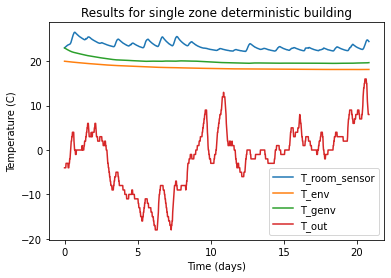

In [6]:
## ------- Visualizing the results -------- ##
T_room_sensor = (
    test_saver_det.file_handler[
        "/zone_sys_det/det_zone_rc_sys/T_room_sensor"
    ][:]
)
T_env = (
    test_saver_det.file_handler["/zone_sys_det/det_zone_rc_sys/T_env"][:]
)
T_genv = (
    test_saver_det.file_handler["/zone_sys_det/det_zone_rc_sys/T_genv"][:]
)
T_out = (
    test_saver_det.file_handler["/zone_sys_det/weather_system/Tout"][:]
)

time = np.arange(max_steps) * 0.5/24
plt.plot(time, T_room_sensor, label='T_room_sensor')
plt.plot(time, T_env, label='T_env')
plt.plot(time, T_genv, label='T_genv')
plt.plot(time, T_out, label='T_out')
plt.ylabel('Temperature (C)')
plt.xlabel('Time (days)')
plt.title('Results for single zone deterministic building')
plt.legend()
plt.show()

In [7]:
# ---------- RC System of a random zone -----------------#
"""
We make the RC system of a non deterministic zone.
"""
# Setting up of file to save simulated results
file_name = "test_make_rc_of_cdcm_random.h5"

if os.path.exists(file_name):
    os.remove(file_name)

file = h5py.File(file_name, "w")

sample_size = 9
building_no = 1
max_steps = 500
test_saver_random = []

from single_zone_random import single_zone_building

for single_zone_building_sample in single_zone_building.sample(sample_size):
    zone = single_zone_building_sample.zones[0]
    neighbor = single_zone_building_sample.neighbor[0]
    
    ## Creating variables to pass while constructing RC system object
    Q_int = Variable(
        name="Q_int",
        units="W",
        value=150,
        description="Sum of internal heat gain",
    )
    T_cor = Variable(
        name="T_cor",
        units="degC",
        value=23,
        description="Corridor temperature",
    )
    u_t = Variable(
        name="u_t", units="W", value=0.0, description="Input loads"
    )
    
    "We create a CDCM system consisiting of clock, weather system and RC system"
    with System(name="zone_sys_random"+str(building_no)) as zone_sys_random:

        ## weather system ##
        weather_sys = make_data_system(
            df[["Tout", "Qsg"]],
            name="weather_system",
            column_units=["degC", "W"],
            column_desciptions=[
                "Outdoor air temperature",
                "Solar irradiance"
            ]
        )

        ## clock system ##
        clock = make_clock(1800)

        ## We make the RC system of a random zone next. ##
        zone_rc_sys = RCBuildingSystem(dt=clock.dt,
                              weather_system=weather_sys,
                              T_cor=T_cor,
                              Q_int=Q_int,
                              u=u_t,
                              name="zone_rc_sys")
    ## fetching information from yabml to cdcm rc system
    zone_rc_sys = make_rc_of_cdcm(zone, neighbor, zone_rc_sys)
    
    group = f"building_{building_no}"
    file.create_group(group)

    for i in range(max_steps):
        zone_sys_random.forward()
        if i == 0:
            test_saver_random.append(SimulationSaver(file[group],
                                        zone_sys_random,
                                        max_steps=max_steps
            )
                              )
        test_saver_random[-1].save()
        zone_sys_random.transition()
    building_no += 1

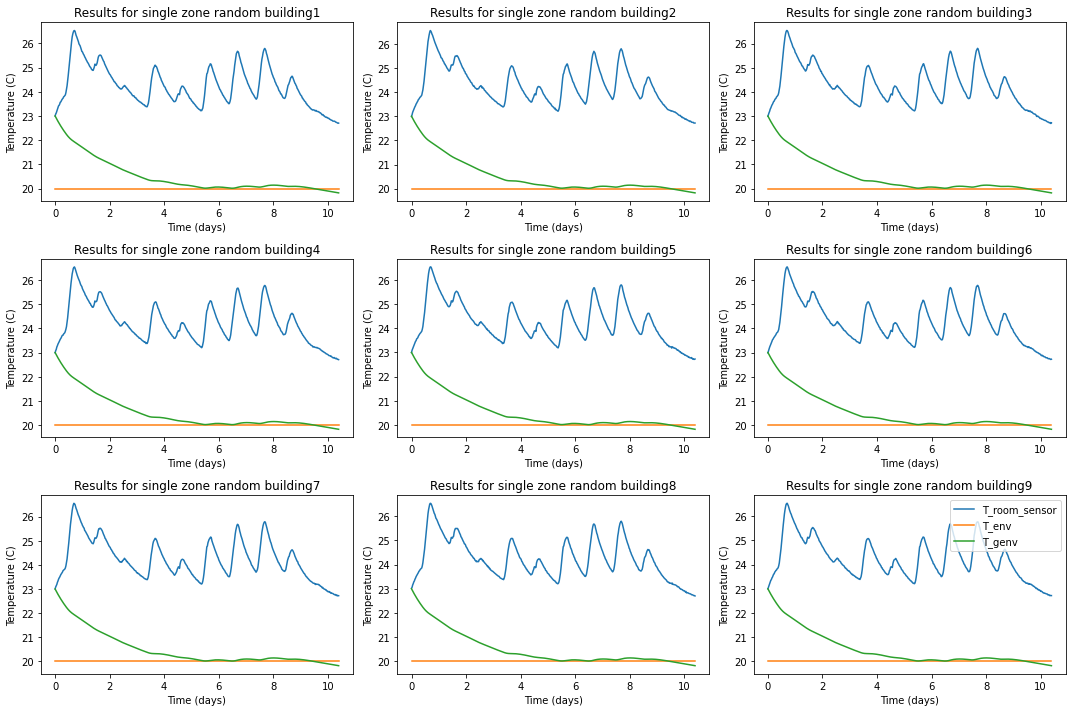

In [8]:
# Code for plotting was taken from here
# https://stackoverflow.com/questions/17210646/python-subplot-within-a-loop-first-panel-appears-in-wrong-position

fig, axs = plt.subplots(3,3, figsize=(15,10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

for building_no in np.arange(9):
    group = f"building_{building_no+1}"
    system_name = "zone_sys_random"+str(building_no+1)
    T_room_sensor = (
        test_saver_random[building_no].group[system_name+"/zone_rc_sys/T_room_sensor"
        ][:]
    )
    T_env = (
        test_saver_random[building_no].group[system_name+"/zone_rc_sys/T_env"][:]
    )
    T_genv = (
        test_saver_random[building_no].group[system_name+"/zone_rc_sys/T_genv"][:]
    )
    T_out = (
        test_saver_random[building_no].group[system_name+"/weather_system/Tout"][:]
    )

    time = np.arange(max_steps) * 0.5/24
    axs[building_no].plot(time, T_room_sensor, label='T_room_sensor')
    axs[building_no].plot(time, T_env, label='T_env')
    axs[building_no].plot(time, T_genv, label='T_genv')
    #axs[building_no].plot(time, T_out, label='T_out')
    axs[building_no].set_ylabel('Temperature (C)')
    axs[building_no].set_xlabel('Time (days)')
    axs[building_no].set_title(f'Results for single zone random building{building_no+1}')
fig.tight_layout()
plt.legend()
plt.show()